In [33]:
import torch
import importlib

import my_modules.nsclc
import my_modules.nsclc.nsclc_dataset
import my_modules.custom_models.classifier_models
importlib.reload(my_modules.nsclc.nsclc_dataset)
from my_modules.nsclc.nsclc_dataset import NSCLCDataset
importlib.reload(my_modules.custom_models.classifier_models)
from my_modules.custom_models.classifier_models import *

Cache reset
Cache reset


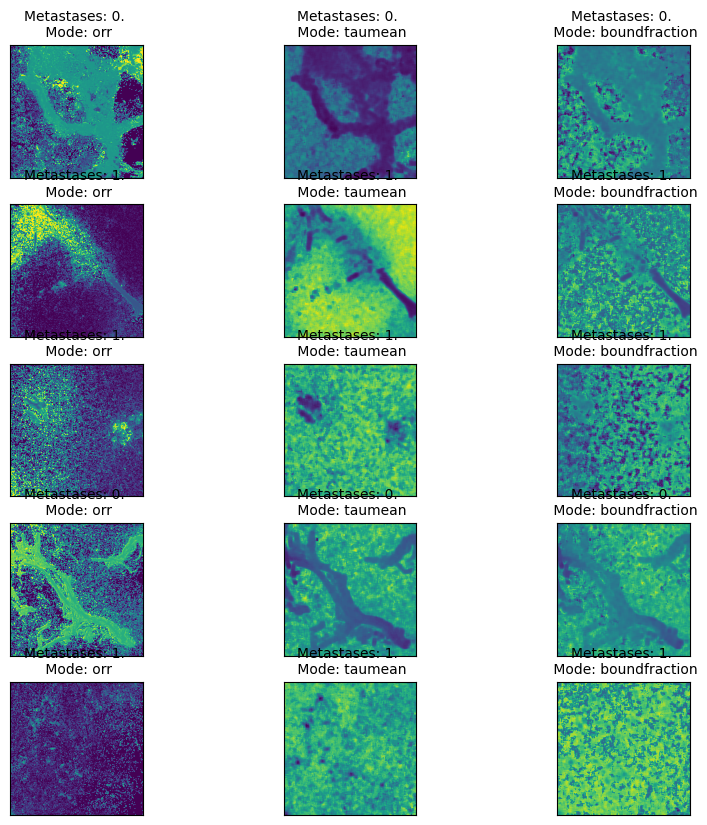

In [34]:
# Load dataset
data = NSCLCDataset('E:\\NSCLC Data - PMD', ['orr', 'taumean', 'boundfraction'], label='M', mask_on=False)
data.normalize_channels_to_max()
data.augment()
data.show_random()

# Metastatic Potential Classification
## Image-based, custom classifier models
### Pre-trained performance evaluation
The following tests are performed on models trained over 125 epochs with a learning rate of 0.01 on augmented, normalized, and unmasked data composed of orr, mean lifetime, and bound fraction images.

In [284]:
models = {'MLP': 
              [MLPNet, 'MLP Net_Epochs-125_nsclc_Metastases_orr+taumean+boundfraction_Augmented_Normalized.pth'],
          'Parallel MLP': 
              [ParallelMLPNet, 'Parallel MLP_Epochs-125_nsclc_Metastases_orr+taumean+boundfraction_Augmented_Normalized.pth'],
          'Regularized MLP': 
              [RegularizedMLPNet, 'Regularized MLP Net_Epochs-125_nsclc_Metastases_orr+taumean+boundfraction_Augmented_Normalized.pth'],
          'Regularized Parallel MLP': 
              [RegularizedParallelMLPNet, 'Regularized Parallel MLP Net_Epochs-125_nsclc_Metastases_orr+taumean+boundfraction_Augmented_Normalized.pth'],
          'CNN':
              [CNNet, 'CN Net_Epochs-125_nsclc_Metastases_orr+taumean+boundfraction_Augmented_Normalized.pth'],
          'Parallel CNN': 
              [ParallelCNNet, 'Parallel CN Net_Epochs-125_nsclc_Metastases_orr+taumean+boundfraction_Augmented_Normalized.pth'],
          'Regularized Parallel CNN': 
              [RegularizedParallelCNNet, 'Regularized Parallel CN Net_Epochs-125_nsclc_Metastases_orr+taumean+boundfraction_Augmented_Normalized.pth']
          }

In [285]:
for model_name, (model_fn, model_path) in models.items():
    # Testing on dataset
    model = model_fn(data.shape)
    model.load_state_dict(
        torch.load(f'models/{model_path}',  map_location=torch.device('cpu')))
    
    model.eval()
    correct = 0
    data_out = []
    data_pred = []
    with torch.no_grad():
        for sample in data:
            out = model(sample[0].unsqueeze(0)).item()
            data_out.append(out)
            pred = np.round(out)
            data_pred.append(pred)
            correct += 1 if pred == sample[1].item() else 0
    print(f'Accuracy of {model_name} over whole dataset: {100*correct / len(data):.2f}%')

Accuracy of MLP over whole dataset: 56.39%
Accuracy of Parallel MLP over whole dataset: 82.71%
Accuracy of Regularized MLP over whole dataset: 86.32%
Accuracy of Regularized Parallel MLP over whole dataset: 89.32%
Accuracy of CNN over whole dataset: 43.61%
Accuracy of Parallel CNN over whole dataset: 65.11%
Accuracy of Regularized Parallel CNN over whole dataset: 86.92%


### Trash in $\rightarrow$ Trash out
As a sanity check, we have pushed through a "random" trash dataset below. We expect that trash in should give trash out. If it does, that is not a strong indication of model efficacy -- that will be addressed next. If it doesn't however, that is a strong indication of model failure.

Trash out we expect to look like a roughly random chance prediction, meaning about half of the predictions will be in either class. If this number starts to shift too high or low for the class, that means the model defaults to a certain class and may be only guessing once class most of the time. Fortunately, our data are failry well balanced (45/55% split), so if this happens on the actual dataset, the performance is limited to 55%. 

In [286]:
def trash_in(model, trash_heap_size=500):
    _in = torch.rand(trash_heap_size, *model.input_size)
    trash_out = []
    model.eval()
    for trash in _in:
        _out = model(trash.unsqueeze(0)).item()
        trash_out.append(_out)
    return trash_out

In [287]:
for model_name, (model_fn, model_path) in models.items():
    model = model_fn(data.shape)
    model.load_state_dict(torch.load(f'models/{model_path}',  map_location=torch.device('cpu')))
    trash_out = trash_in(model, 500)
    print(f'Trash into {model_name} resulted in {100*sum(trash_out) / len(trash_out):.2f}% of outputs being positively classified')

Trash into MLP resulted in 59.69% of outputs being positivley classified
Trash into Parallel MLP resulted in 87.55% of outputs being positivley classified
Trash into Regularized MLP resulted in 100.00% of outputs being positivley classified
Trash into Regularized Parallel MLP resulted in 99.15% of outputs being positivley classified
Trash into CNN resulted in 50.00% of outputs being positivley classified
Trash into Parallel CNN resulted in 61.58% of outputs being positivley classified
Trash into Regularized Parallel CNN resulted in 100.00% of outputs being positivley classified


### 5-Fold Cross Validation
To assess efficacy, We will take the best performing models from this group (parallel MLPs and parallel CNNs) and perform 5-Fold Cross Validation to obtain more robust measures of performance for these models. For each fold, we will score raw accuracy and ROC-AUC.

#### Functions
Defining some useful functions so we can limit code copying

In [18]:
from my_modules.model_learning import train_epoch, test_model

def FiveFoldCrossValidation(model_fn, data_folds, epochs=125, learning_rate=0.01):
    accuracy = []
    running_loss = []
    for fold, test_set in enumerate(data_folds):
        model = model_fn(data.shape)
        train_sets = [data_folds[index] for index in range(5) if index != fold]
        train_set = torch.utils.data.ConcatDataset(train_sets)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
        optimizer = optimizer_fn(model.parameters(), lr=learning_rate)
        
        model.train()
        if torch.cuda.is_available() and not next(model.parameters()).is_cuda:
            model.to(torch.device('cuda'))
        for epoch in range(epochs):
            model.train(True)
            loss = train_epoch(model, train_loader, loss_fn, optimizer)
            running_loss.append(loss)
        model.eval()
        correct = test_model(model, test_loader)
        accuracy.append(100*correct/len(test_loader.sampler))
        models.append(model)
        print(f'{model.name} accuracy for fold {fold+1}: {accuracy[-1]:.2f}%')
    print(f'>>>{model.name} average accuracy: {sum(accuracy)/len(accuracy):.2f}%<<<')
    return accuracy, running_loss, models

In [14]:
def fold_augmented_data(data, num_folds=5, augmentation_factor=5):
    
    # Randomly sample indices from augmented dataset that are _only_ indices of main images
    subsampler = torch.utils.data.SubsetRandomSampler(range(0, len(data), augmentation_factor))
    
    # Read the subsampler
    indices = [i for i in subsampler]
    
    data_folds = []
    for fold in range(num_folds):
        # Get the parent sample indices for the first 1/num_folds samples 
        main_parents = indices[fold * int(len(subsampler) / num_folds): int((fold + 1) * (len(subsampler) / num_folds))]
        
        # Get the all (number depends on augmentation_factor) the children indices from those indices
        augmented_children = [parent_idx + child_idx for parent_idx in main_parents for child_idx in range(augmentation_factor)]
        
        # Now actually subset the data
        data_folds.append(torch.utils.data.Subset(data, augmented_children))
    return data_folds
    

Now we can use those functions to easily test our best-performers.

In [319]:
best_models = [RegularizedParallelMLPNet, RegularizedParallelCNNet]
# Create folds by random sampling then multiplying samples by dataset numbers to augment without repeating slides in any group
data_folds = fold_augmented_data(data)
batch_size = 32
learning_rate = 0.01
loss_fn = nn.BCELoss()
optimizer_fn = torch.optim.SGD
for model_fn in best_models:
    accuracy, running_loss, _  = FiveFoldCrossValidation(model_fn, data_folds, epochs=125, learning_rate=0.01)

We can also go ahead and run this test again with the masks on. If any of these models perform notably well, we can select them out and run 5-Fold Cross Validation across multiple hyperparameter sets to really fine tune things.

In [ ]:
data.mask_on = True
for model_fn in best_models:
    accuracy, running_loss, _  = FiveFoldCrossValidation(model_fn, data_folds, epochs=125, learning_rate=0.01)

## Histogram-based custom classifier models
First, we need to transform the dataset to match how the upcoming modes were trained. We can also take a look at some random samples to get an idea of what the model sees.

Cache reset
Cache reset


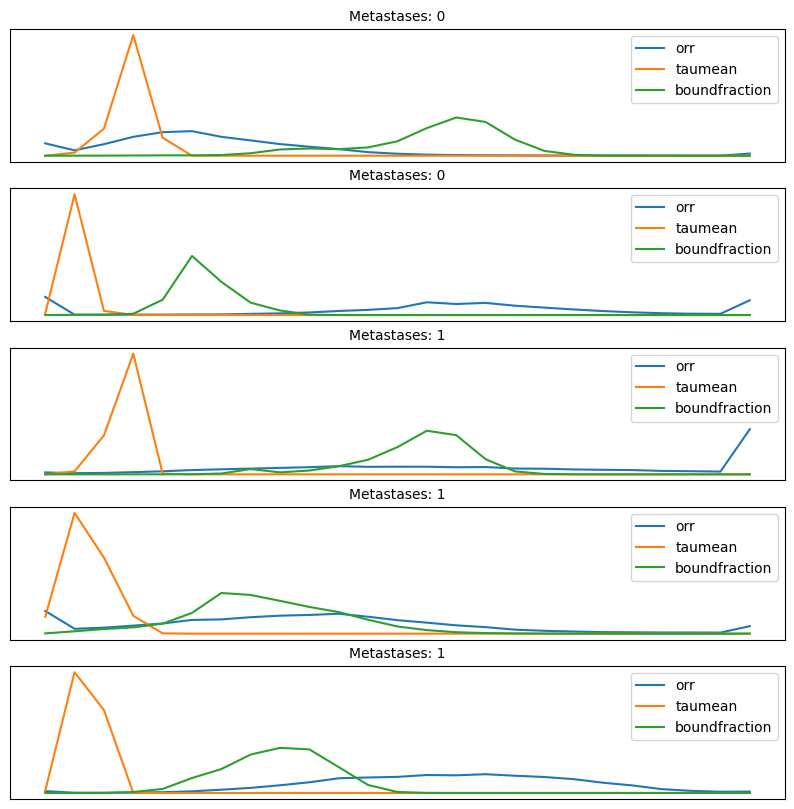

In [293]:
data.dist_transform(nbins=25)
data.mask_on = False
data.show_random()

### Testing Pre-trained Models
These models are from a training session on the HPC. They were trained over varius hyperparameters and on the GPU. Some models were clearly better than others; accordingly, we already selected out the best performing architectures and are now comparing those models over a the gamut of hyperparams. 

In [325]:
models = {'Fast MLP': 
              [MLPNet, 'MLP Net_Epochs-125_nsclc_Metastases_orr+taumean+boundfraction_Transformed_Augmented_Normalized.pth'],
          'Medium MLP': 
              [MLPNet, 'MLP Net_Epochs-250_nsclc_Metastases_orr+taumean+boundfraction_Transformed_Augmented_Normalized.pth'],
          'Slow MLP': 
              [MLPNet, 'MLP Net_Epochs-500_nsclc_Metastases_orr+taumean+boundfraction_Transformed_Augmented_Normalized.pth'],
          'Fast RNN':
              [RNNet, 'RN Net_Epochs-125_nsclc_Metastases_orr+taumean+boundfraction_Transformed_Augmented_Normalized.pth'],
          'Medium RNN': 
              [RNNet, 'RN Net_Epochs-250_nsclc_Metastases_orr+taumean+boundfraction_Transformed_Augmented_Normalized.pth'],
          'Slow RNN': 
              [RNNet, 'RN Net_Epochs-500_nsclc_Metastases_orr+taumean+boundfraction_Transformed_Augmented_Normalized.pth'],
          }

In [326]:
for model_name, (model_fn, model_path) in models.items():
    # Testing on dataset
    model = model_fn(data.shape)
    model.load_state_dict(
        torch.load(f'models/{model_path}', map_location=torch.device('cpu')))
    
    model.eval()
    correct = 0
    data_out = []
    data_pred = []
    with torch.no_grad():
        for sample in data:
            out = model(sample[0].unsqueeze(0)).item()
            data_out.append(out)
            pred = np.round(out)
            data_pred.append(pred)
            correct += 1 if pred == sample[1].item() else 0
    print(f'Accuracy of {model_name} over whole dataset: {100*correct / len(data):.2f}%')

Accuracy of Fast MLP over whole dataset: 90.53%
Accuracy of Medium MLP over whole dataset: 82.11%
Accuracy of Slow MLP over whole dataset: 66.32%
Accuracy of Fast RNN over whole dataset: 60.00%
Accuracy of Medium RNN over whole dataset: 56.39%
Accuracy of Slow RNN over whole dataset: 55.19%


#### Trash in $\rightarrow$ Trash out Test

In [327]:
for model_name, (model_fn, model_path) in models.items():
    model = model_fn(data.shape)
    model.load_state_dict(torch.load(f'models/{model_path}',  map_location=torch.device('cpu')))
    trash_out = trash_in(model, 500)
    print(f'Trash into {model_name} resulted in {100*sum(trash_out) / len(trash_out):.2f}% of outputs being positivley classified')

Trash into Fast MLP resulted in 61.59% of outputs being positivley classified
Trash into Medium MLP resulted in 59.97% of outputs being positivley classified
Trash into Slow MLP resulted in 52.27% of outputs being positivley classified
Trash into Fast RNN resulted in 58.64% of outputs being positivley classified
Trash into Medium RNN resulted in 52.95% of outputs being positivley classified
Trash into Slow RNN resulted in 50.18% of outputs being positivley classified


### 5-Fold Cross Validation 
First, we will use the basic and fast hyperparameters of 125 epochs with a learning rate of 0.01. 

In [328]:
best_models = [MLPNet, ParallelMLPNet, RNNet]
lengths = [int(0.2 * len(data)) for _ in range(5)]
data_folds = torch.utils.data.random_split(dataset=data, lengths=lengths)

In [335]:
for model_fn in best_models:
    accuracy, running_loss, _ = FiveFoldCrossValidation(model_fn, data_folds, epochs=125, learning_rate=0.01)

MLP Net accuracy for fold 1: 87.97%
MLP Net accuracy for fold 2: 76.69%
MLP Net accuracy for fold 3: 87.97%
MLP Net accuracy for fold 4: 81.20%
MLP Net accuracy for fold 5: 78.20%
>>>MLP Net average accuracy: 82.41%<<<
Parallel MLP accuracy for fold 1: 67.67%
Parallel MLP accuracy for fold 2: 71.43%
Parallel MLP accuracy for fold 3: 78.95%
Parallel MLP accuracy for fold 4: 67.67%
Parallel MLP accuracy for fold 5: 81.20%
>>>Parallel MLP average accuracy: 73.38%<<<
RN Net accuracy for fold 1: 63.16%
RN Net accuracy for fold 2: 60.90%
RN Net accuracy for fold 3: 59.40%
RN Net accuracy for fold 4: 58.65%
RN Net accuracy for fold 5: 64.66%
>>>RN Net average accuracy: 61.35%<<<


Next, we will iterate through a gamut of hyperparameters to try to find the best combination. Becasue the histogrma transformation saves so much model-complexity, we can afford to do this for all models out of the gate.

In [336]:
# Try different hyperparameters in 5-Fold
epochs = [125, 250, 500, 1000, 2500]
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
for ep in epochs:
    for lr in learning_rates:
        print(f'\nEpochs: {ep} -- Learning Rate: {lr}\n______________________________________')
        for model_fn in best_models:
            accuracy, running_loss, _ = FiveFoldCrossValidation(model_fn, data_folds, epochs=ep, learning_rate=lr)
            print('______________________________________')


Epochs: 125 -- Learning Rate: 0.1
______________________________________
MLP Net accuracy for fold 1: 88.72%
MLP Net accuracy for fold 2: 82.71%
MLP Net accuracy for fold 3: 90.23%
MLP Net accuracy for fold 4: 80.45%
MLP Net accuracy for fold 5: 84.96%
>>>MLP Net average accuracy: 85.41%<<<
______________________________________
Parallel MLP accuracy for fold 1: 78.95%
Parallel MLP accuracy for fold 2: 78.95%
Parallel MLP accuracy for fold 3: 85.71%
Parallel MLP accuracy for fold 4: 73.68%
Parallel MLP accuracy for fold 5: 84.96%
>>>Parallel MLP average accuracy: 80.45%<<<
______________________________________
RN Net accuracy for fold 1: 81.95%
RN Net accuracy for fold 2: 76.69%
RN Net accuracy for fold 3: 84.21%
RN Net accuracy for fold 4: 78.95%
RN Net accuracy for fold 5: 72.18%
>>>RN Net average accuracy: 78.80%<<<
______________________________________

Epochs: 125 -- Learning Rate: 0.01
______________________________________
MLP Net accuracy for fold 1: 80.45%
MLP Net accuracy 

Finally, we will repeat this hyperparemeter iteration for the dataset with masks back on.

In [ ]:
data.mask_on = True
for ep in epochs:
    for lr in learning_rates:
        print(f'\nEpochs: {ep} -- Learning Rate: {lr}\n______________________________________')
        for model_fn in best_models:
            accuracy, running_loss, _ = FiveFoldCrossValidation(model_fn, data_folds, epochs=ep, learning_rate=lr)
            print('______________________________________')

# InceptionResNev2 + regularized MLP Classifier
This will use the exact specification fo the model architecture form the included source. In short, InceptionResNetV2 is used to extract feature maps which are then averaged to obtain asort of "feature spectrum." This is a nice way to add some depth to our model without adding a necessity for more data. InceptionResNetV2 is very deep (164 layers and 15 million parameers, I believe), but we aren't training it at all, so we don't have to worry about overfitting. We will just use the feature maps to train an MLP with 2 hidden layers each with dropouts to classify the liklihood of metastasis. This MP works very simililary to my Regualrized MLP Nets, but instead of outputting a binary class () or 1) it outputs a two-class liklihood (y, 1-(y)). To train, we will have to expand the original data labels to match this output, but functionally, it shouldn't change the question the model is trying to answer,. In fact this gives us better granualirty, as we will see driectly how certaiin the model is about the class prediciton.

> Schiele S, Arndt TT, Martin B, et al. Deep Learning Prediction of Metastasis in Locally Advanced Colon Cancer Using Binary Histologic Tumor Images. Cancers (Basel). 2021;13(9):2074. Published 2021 Apr 25. doi:10.3390/cancers13092074

In [430]:
from pretrainedmodels import inceptionresnetv2
# NOTE: The automatica weight download for InceptionResNetV2 is broken. Model msut be manually downloaded from https://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth and placed in C:/Users/<username>/.cache/torch/hub/checkpoints/
# Setup the dataset for this model
# Images, no mask (feature extractor will hopefully handle this), normalized (already is), 
data.mask_on = False
data.dist_transformed = False

batch_size = 21
learning_rate = 0.0005
optim_fn = torch.optim.RMSprop
epochs = 300
loss_fn = torch.nn.CrossEntropyLoss()

# Define our base feature extractor and turn the gradients off -- we won't train it, just use it to feed our MLP.
feature_extractor = inceptionresnetv2(num_classes=1000, pretrained='imagenet') # outputs 1536 feature maps when called with .features(x)
for params in feature_extractor.parameters():
    params.requires_grad = False


# Dry run feature extractor to get output dims for classifier creation
feature_extractor.eval()
with torch.no_grad():
    x = torch.rand(batch_size, data.shape[0], data.shape[1], data.shape[2])
    dry_run = feature_extractor.features(x)
feature_map_dims = dry_run.shape

In [464]:
# Create classifier
class classifier(nn.Module):
    def __init__(self, input_size, feature_extractor):
        super(classifier, self).__init__()
        self.feature_extractor = feature_extractor
        self.input_size = input_size
        self.feature_map_dims = self.get_features(torch.rand(1, *input_size))
        
        self.GlobalAvgPool = nn.AvgPool2d(feature_map_dims[-2::], stride=2) # Get average value for each feature map (1536 feature values/image)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(1536, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.2)
        
    def forward(self, x):
        # Extract features
        x = self.get_features(x)
        
        # Classify
        x = self.GlobalAvgPool(x)
        x = self.flat(x)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
    
    def get_features(self, x):
        return self.feature_extractor(x)

In [467]:
# Check that shapes are as expected
m = classifier(x.shape[1:], feature_extractor.features)
out = m(x)
print(f'Input shape {x.shape}')
print(f'After feature extraction: {m.get_features(x).shape}')
print(f'After classifier: {out.shape}')

Input shape torch.Size([21, 3, 256, 256])
After feature extraction: torch.Size([21, 1536, 6, 6])
After classifier: torch.Size([21, 2])


In [ ]:
models = []
accuracy = []
running_loss
for fold, test_set in enumerate(data_folds):
    # Make model, loaders, & optimizer for fold
    model = classifier(data.shape, feature_extractor.features)
    train_sets = [data_folds[index] for index in range(5) if index != fold]
    train_set = torch.utils.data.ConcatDataset(train_sets)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    optimizer = optimizer_fn(model.parameters(), lr=learning_rate)
    
    # Train
    model.train()
    for ep in range(epochs):
        print(f'Epoch: {ep}')
        for x, target in train_loader:
            # Extract features
            out = model(x)
            
            # Array to reform target to look like out
            y = torch.zeros_like(out) 
            
            # Put 100% certainty on the class
            for r, t in enumerate(target):
                y[r, t] = 1
            
            loss = loss_fn(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss.append(loss.item())
    # Test
    correct = 0
    for x, target in test_loader:
        out = model(x)
        pred = torch.argmax(out)
        correct += 1 if pred == target.item() else 0
        accuracy.append(100*correct/len(test_loader.sampler))
        models.append(model) 
        print(f'Inception + MLP accuracy for fold {fold+1}: {accuracy[-1]:.2f}%')
print(f'>>>Inception + MLP average accuracy: {sum(accuracy)/len(accuracy):.2f}%<<<')

# Manual Feature Extraction and Revision
Using the best performing models from 5-Fold Cross Validation, we will do some rudimentary feature extraction to refine the models. Training for 1000 epochs with a learning rate of 0.01 on histogram data proved to be the best overall method, yielding the highest overall accuracy (MLP Net with accuracy of 87.82%) and yielding relatively high accuracies for all networks (all three in >80%). We will train a fresh MLP Net with those settings and then average the 5 models to use for further analysis.

In [504]:
data.dist_transform()
data.mask_on = False
model_fn = MLPNet
accuracy, running_loss, models = FiveFoldCrossValidation(model_fn, data_folds, epochs=1000, learning_rate=0.01)

Cache reset
Cache reset
MLP Net accuracy for fold 1: 88.72%
MLP Net accuracy for fold 2: 83.46%
MLP Net accuracy for fold 3: 88.72%
MLP Net accuracy for fold 4: 84.21%
MLP Net accuracy for fold 5: 88.72%
>>>MLP Net average accuracy: 86.77%<<<


In [542]:
from torchinfo import summary
summary(models[0], input_size=(batch_size,)+data.shape)

Layer (type:depth-idx)                   Output Shape              Param #
MLPNet                                   [21, 1]                   --
├─Flatten: 1-1                           [21, 75]                  --
├─Linear: 1-2                            [21, 512]                 38,912
├─ReLU: 1-3                              [21, 512]                 --
├─Linear: 1-4                            [21, 512]                 262,656
├─ReLU: 1-5                              [21, 512]                 --
├─Linear: 1-6                            [21, 1]                   513
├─Sigmoid: 1-7                           [21, 1]                   --
Total params: 302,081
Trainable params: 302,081
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 6.34
Input size (MB): 0.01
Forward/backward pass size (MB): 0.17
Params size (MB): 1.21
Estimated Total Size (MB): 1.39

In [568]:
# Get all params for each of the 5 models
sd = [m.state_dict() for m in models]
final_sd = {}

# Average all parameters into final state dict
for key in sd[0]:
    final_sd[key] = (sd[0][key] + sd[1][key] + sd[2][key] + sd[3][key] + sd[4][key]) / 5

# Create final model and run one final test on entire dataset
final_model = MLPNet(data.shape)
final_model.load_state_dict(final_sd)
all_data_loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)
correct = test_model(final_model, all_data_loader)
print(f'Accuracy on whole dataset: {100* correct / len(all_data_loader.sampler):0.2f}%')

Accuracy on whole dataset: 70.38%


This accuracy is much worse than the accuracy of any of the individual models over the entire dataset. This is a good indication that that the models are not neccessarily reaching a global minimum in the loss function. That's not a terrible thing, but it does mean that the model needs to be generalized carefully. To this end, we are going to test an ensemble of models (since its so stinking light weight) to see if that is better. Then, we will proceed with feature extraction. But before any of that, look at the performance of the models on the entire dataset:

In [569]:
for model in models:
    correct = test_model(model, all_data_loader)
    print(f'Accuracy on whole dataset: {100* correct / len(all_data_loader.sampler):0.2f}%')

Accuracy on whole dataset: 96.99%
Accuracy on whole dataset: 96.24%
Accuracy on whole dataset: 96.84%
Accuracy on whole dataset: 96.24%
Accuracy on whole dataset: 97.14%


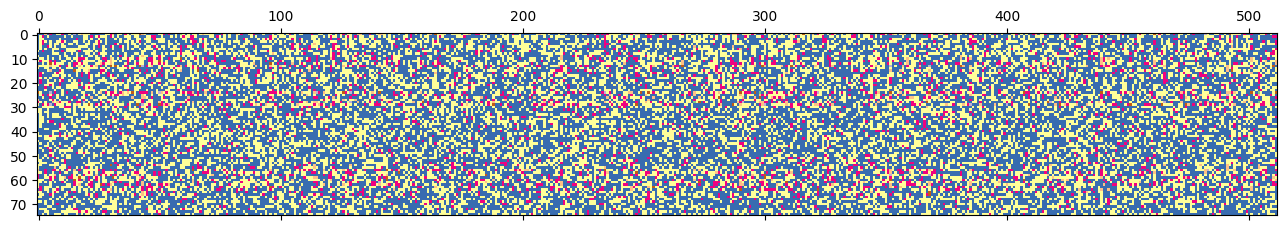

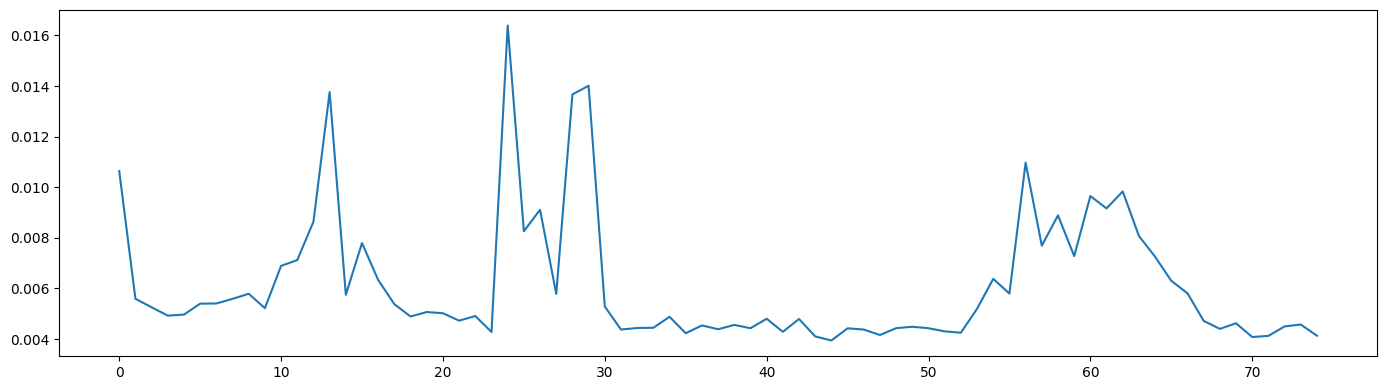

test


In [631]:
# For now, just take the best model of the 5
import matplotlib.pyplot as plt
model = models[-1]
sd = model.state_dict()
weight_mat = sd['fc1.weight'].T
plt.matshow(weight_mat, cmap=plt.cm.Accent)
plt.show()

weight_var = torch.var(weight_mat, axis=1)
fig2 = plt.figure(figsize=(17, 4.5))
plt.plot(weight_var)
plt.show()
print('test')

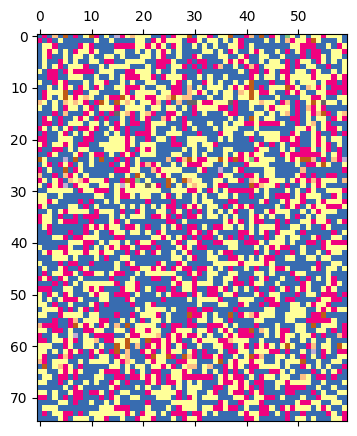

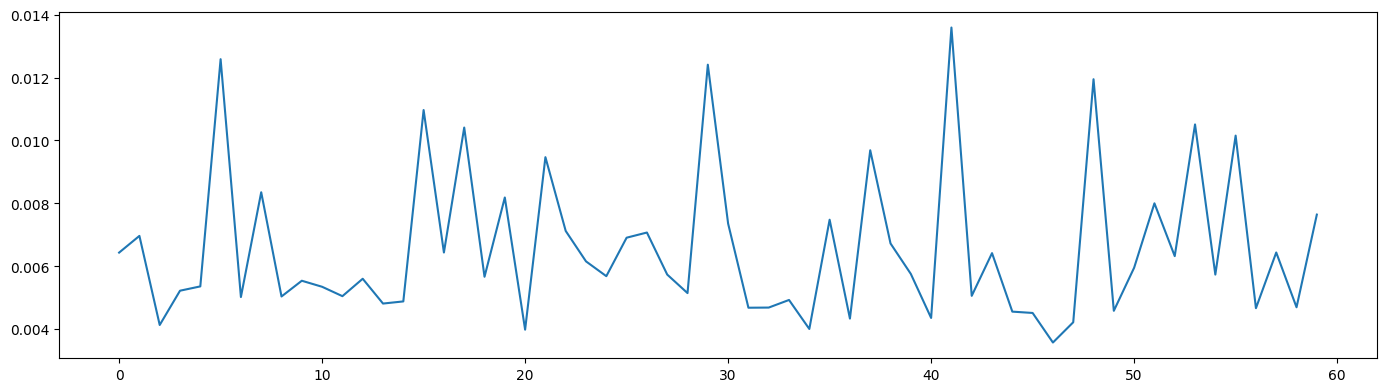

In [636]:
# Select out input nodes that are just blanket connected with very little variance (e.g. 30-50)
top_quart = sorted(weight_var, reverse=True)[:round(.8*len(weight_var))]
selection = []
for w8 in weight_var:
  fnd = w8 in top_quart
  selection.append(fnd)
sel_weights = np.array([weight for weight, select in zip(weight_mat.T, selection) if select])

fig = plt.matshow(sel_weights.T, cmap=plt.cm.Accent)
plt.show()

sel_weight_var = np.var(sel_weights.T, axis=0)
fig2 = plt.figure(figsize=(17, 4.5))
plt.plot(sel_weight_var)
plt.show()

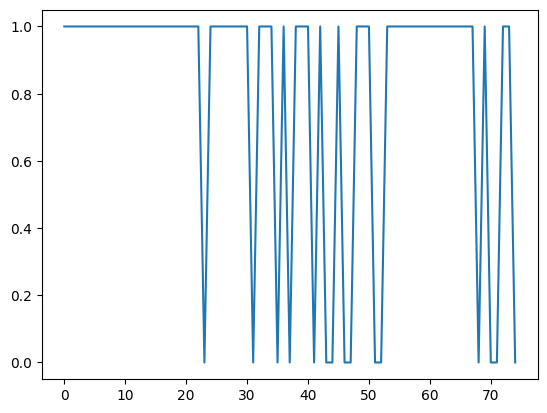

In [645]:
# Retrain on selected features and test
plt.plot(selection)

In [607]:
# Create ensemble of models
correct = 0
for x, target in all_data_loader:
    out = torch.mean(torch.stack([m(x) for m in models]), dim=0) # Get individual model outputs and then average them 
    pred = torch.round(out) # Get final prediction from rounding
    correct += torch.sum(pred.squeeze() == target).item()
print(f'Ensemble accuracy over all data set: {100 * correct / len(all_data_loader.sampler):0.2f}%')

Ensemble accuracy over all data set: 99.25%


This is super good, so we need to do something to check it. Obviously this isn't very robust becasue we've seen all this data before, even though no one model has seen it all, any piece of data 4/5 models ahve trained on. So what we can do is hold out just a few samples from all training, then use those as a final test set for the ensemble.

In [ ]:
##### TODO: Handle the above #####

## Model with all modes

In [ ]:
# Prep hyperparams
epochs = 125
learning_rate = 0.01
batch_size = 32
optimizer_fn = torch.optim.SGD
loss_fn = nn.BCEWithLogitsLoss()

# Prep data
data.mode = ['all']
data.mask_on = False
data_folds = fold_augmented_data(data)
model_fn = MLPNet
accuracy, running_loss, models = FiveFoldCrossValidation(model_fn, data_folds, epochs=125, learning_rate=0.01)

Cache reset


# Off-the-shelf classifiers

In [ ]:
import torchvision
import torchvision.models as tvm
torchvision.models.list_models()

In [ ]:
models = [tvm.mobilenet_v3_small, tvm.squeezenet1_1, tvm.alexnet, tvm.GoogLeNet]

In [ ]:
for model_fn in models:
    # Testing on dataset
    model = model_fn()
    
    model.eval()
    correct = 0
    data_out = []
    data_pred = []
    with torch.no_grad():
        for sample in data:
            out = model(sample[0].unsqueeze(0))
            pred = torch.argmax(out).item()
            data_pred.append(pred)
            correct += 1 if pred == sample[1].item() else 0
    print(f'Accuracy of {type(model)} over whole dataset: {100*correct / len(data):.2f}%')

In [ ]:
for model_fn in models:
    accuracy = []
    running_loss = []
    for fold, test_set in enumerate(data_folds):
        model = model_fn()
        train_sets = [data_folds[index] for index in range(5) if index != fold]
        train_set = torch.utils.data.ConcatDataset(train_sets)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
        optimizer = optimizer_fn(model.parameters(), lr=lr)
        
        model.train()
        if torch.cuda.is_available() and not next(model.parameters()).is_cuda:
            model.to(torch.device('cuda'))
        total_loss = []
        for epoch in range(125):
            model.train(True)
            for x, target in train_loader:
                out = model(x).squeeze()
                # Convert out from one-hot encoding
                y = out/torch.sum(out)
                y = out[target] / (1 - out[target])
                loss = loss_fn(y, target)
                total_loss += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            running_loss.append(total_loss)
        model.eval()
        correct = 0
        for x, target in test_loader:
            out = model(x).squeeze()
            # Convert out from one-hot encoding
            pred = torch.argmax(out).item()
            correct += (pred == target).sum().item()
        accuracy.append(100*correct/len(test_loader.sampler))
        print(f'{model.name} accuracy for fold {fold+1}: {accuracy[-1]:.2f}%')
    print(f'{model.name} average accuracy: {sum(accuracy)/len(accuracy):.2f}%')
    plt.plot(running_loss)
    plt.show()

# Results Decision
While these results are poor, the training parameters for these models was not expected to be ideal at only 125 epochs and a high learning rate. From these models, we will choose the best performers of both MLPs (for both image and histograms), CNNs, and RNNs and retrain on an array of hyperparameters to find the optimized model training. From those, the best will be characterized for final results.

## Results Summary for Image-based Classifiers
While the MLP-based networks showed some promising results (with the parallel MLPs reaching accuracies >80%), the parallel CNNs outperform all MLP-based networks and are of comparable weight to a fully-connected MLP through the use of kernels rather than dense layers. Interestingly, a basic CNN was the worst performer by a notable margin. This may be due to the increased level of complexity that the model must learn to detect relationships across dimensions, while not adding appropriate numbers of trainable parameters or increased data-size. Both parallel models performed excellently with accuracies >90%. The regularized parallel network only slightly outperforms the parallel network, but adds no new trainable parameters (and only 9KB to the model size) and should make performance generally more stable.

These models were all trained, evaluated, and tested originally on subsets of the entire dataset, but the tests shown here are across the entire dataset, meaning overfitting would be strongly reflected in the results. More robust checks for the best performers are below.